# Modeling the Spread of Infectious Diseases

## Introduction

While mathematics is stunningly beautiful in its purest, most theoretical form, most of the appeal in studying math comes from the variety of ways in which it can be applied. One of these applications is mathematical modeling via ordinary differential equations -- an umbrella term for numerical techniques that describe and simulate the dynamic evolution of a time-dependent system.

Pandemics are one *incredibly* relevant dynamic system that is worth understanding. In the literature, mathematical approximations of disease spread are built off of a class of models known as **SIR** (the acronym stands for **S**usceptible, **I**nfectious, and **R**ecovered).

## SIR Model Breakdown

In its most basic form, an SIR model consists of the following differential equations (all describing how the system changes with respect to time):

$\frac{dS}{dt} = -\beta S(t)I(t)$

$\frac{dI}{dt} = \beta I(t)S(t) - \gamma I(t)$

$\frac{dR}{dt} = \gamma I(t)$

Note the use of constants $\beta$ and $\gamma$. These control, respectively, the rate at which infectious individuals spread a disease to susceptible individuals and the rate at which infected individuals recover from the disease. Different values for $\beta$ and $\gamma$ will result in radically different behavior that can approximate many classes of pathogens.

Also observe the way this system is currently set up: 

$\frac{dS}{dt} + \frac{dI}{dt} + \frac{dR}{dt} = 0$

This means that we are assuming the total number of individuals in the population remains constant (i.e. # of births and # of deaths are offsetting). With most populations over a short period of time, this assumption isn't as strong as it seems. It is also common to set $S(t) + I(t) + R(t) = 1$ so that values represent proportions of a population rather than actual number of individuals infected.

Another key assumption for this model that doesn't always hold up in reality is that there are no reinfections -- a person who transitions to the "recovered" state will stay there. This can be adjusted in a number of ways, but I will stay simple for this demonstration.

More elaboration could be given here on how the SIR model is actually constructed (for example, why do we choose to model the interaction between the infected and the susceptible as a product instead of some other mathematical abstraction?), but for now I will just refer you to [this helpful Wikipedia page](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology).

Let's dive in and see some SIR models at work!

## Scenario 1

Let's pretend we're modeling a pandemic in a made-up city of ~3 million. Now imagine that 5 people have just entered the city carrying a new disease. In this imaginary disaster, we will also assume that each sick person has one contact/day that will spread the disease (i.e. $\beta = 1$).

For those who are infected with this disease, it takes roughly 3 days to recover (so about 1/3 of the infected will recover each day, i.e. $\gamma = \frac{1}{3}$).

With no preventative measures taken, how can we simulate the spread of this disease throughout the city over a 50-day period? We can put an SIR model to the test.

We first import the necessary libraries that will make coding up (and finding a solution of) this model easier:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp, solve_bvp
from scipy.optimize import minimize

Now, we define key parameters from the problem setup:

In [3]:
population = 3e6
initial_infected = 5 / population
initial_susceptible = (population - initial_infected) / population
initial_recovered = 0

contacts_per_day = 1
daily_proportion_recovered = 1/3

# We want to look at the first 50 days, solving with the granularity of 2 y values per day.
initial_day = 0
final_day = 50
timesteps = 1/2 * np.arange(101)

At this point, we can set up the system and solve it numerically using the ODE solver found in `scipy`:

In [4]:
def SIR(t, y):
    return np.array(
        [
            -contacts_per_day * y[0] * y[1],
            contacts_per_day * y[0] * y[1] - daily_proportion_recovered * y[1],
            daily_proportion_recovered * y[1],
        ]
    )
    
initial_conditions = np.array([initial_susceptible, initial_infected, initial_recovered])
solution = solve_ivp(SIR, (initial_day, final_day), initial_conditions, t_eval=timesteps)    

Plotting the results, we can see how the disease evolves over time:

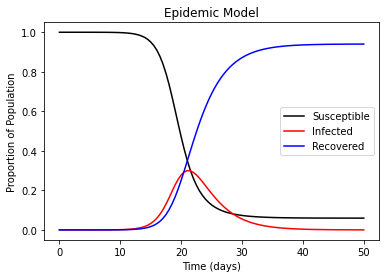

In [5]:
plt.plot(timesteps, solution.y[0], label="Susceptible", c="black")
plt.plot(timesteps, solution.y[1], label="Infected", c="red")
plt.plot(timesteps, solution.y[2], label="Recovered", c="blue")
plt.xlabel("Time (days)")
plt.ylabel("Proportion of Population")
plt.legend()
plt.title("Epidemic Model")
plt.show()

With our basic mathematical model, we can now forecast what will happen in our imaginary city if no precautions are instituted by its local government / civilians. It looks like with the current amount of information, we expect infections to peak at around 30% of the city's population in the 20-30 day range. If decision makers conclude that a peak like this is unacceptable and will overwhelm city resources, perhaps efforts can be made to change the system (precautions like social distancing could lower the $\beta$ value, which will in turn "slow the spread" and reduce peak demand on medical resources).

Here's what that alternative scenario would look like (assuming precautions are now taken to "flatten the curve"):

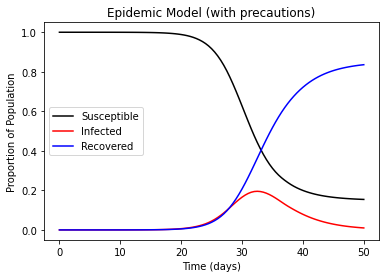

In [6]:
contacts_per_day = 0.75 # Was originally 1

def SIR_modified(t, y):
    return np.array(
        [
            -contacts_per_day * y[0] * y[1],
            contacts_per_day * y[0] * y[1] - daily_proportion_recovered * y[1],
            daily_proportion_recovered * y[1],
        ]
    )
    
initial_conditions = np.array([initial_susceptible, initial_infected, initial_recovered])
solution = solve_ivp(SIR, (initial_day, final_day), initial_conditions, t_eval=timesteps)   

plt.plot(timesteps, solution.y[0], label="Susceptible", c="black")
plt.plot(timesteps, solution.y[1], label="Infected", c="red")
plt.plot(timesteps, solution.y[2], label="Recovered", c="blue")
plt.xlabel("Time (days)")
plt.ylabel("Proportion of Population")
plt.legend()
plt.title("Epidemic Model (with precautions)")
plt.show()

Thus, if all city leaders are able to do is lower the average spread of the disease to 0.75 infectious contacts / day for each sick individual, dramatic changes will occur -- now the peak of the pandemic is at 20% of the population instead of 30%!

(This is what everybody meant back in 2020 when "flatten the curve" was trending).

## Scenario 2

In practice, it makes much more sense to learn parameters of a mathematical model from existing / similar data (rather than to make assumptions and guesses, although those can still be quite practical given limited resources).

This approach can be implemented through minimization techniques -- in which we make initial guesses for the parameters of our model, then repeatedly solve the model with those parameters and compare it to actual data over the same time period. With smart updates to parameters (using any of the many variants of gradient descent), we can converge to optimal parameters that help our model most closely mimic real-world behavior.

In the code that follows, I fit a PGED model (which is really just a more complicated SIR model) to some actual data from New York City when the first COVID breakout occurred there.

We start with loading our data and setting the initial conditions for our system (note that New York City had a population of around 8.4 million in 2020):

In [10]:
case_data = np.load("new_york_cases.npy")

population = 8.399e6
initial_infected = case_data[0] / population
initial_susceptible = (population - initial_infected) / population
initial_recovered = 0

initial_day = 1
final_day = len(case_data)

timesteps = np.arange(1, final_day + 1)
initial_conditions = np.array([initial_susceptible, initial_infected, initial_recovered])

We now define the PGED model (with parameters $\alpha$ and $T_G$):

In [12]:
def PGED(t, y, alpha, tg):
    return np.array(
        [
            -(alpha / t) * y[1],
            ((alpha / t) - (1 / tg)) * y[1],
            (1 / tg) * y[1],
        ]
    )

With the PGED model set up, we now set up code to repeatedly solve it with varied parameters, seeking to minimize the normed distance from the actual data.

In [13]:
# This function solves the ODE with the given parameters and returns the error from the actual data.
def model(params):

    alpha, tg = params

    # Solve system and see how close we are.
    solution = solve_ivp(PGED, (initial_day, final_day), initial_conditions, t_eval=timesteps, args=(alpha, tg)) 
    return np.linalg.norm((1 - solution.y[0]) - (case_data / population))

# Set initial guesses and fit to data.
p0 = (3.2, 22.8)
alpha, tg = minimize(model, p0).x

final_solution = solve_ivp(PGED, (initial_day, final_day), initial_conditions, t_eval=timesteps, args=(alpha, tg))

We can now plot our results to see how good our fit is:

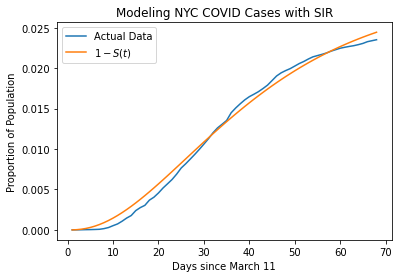

In [14]:
plt.title("Modeling NYC COVID Cases with SIR")
plt.plot(timesteps, case_data / population, label="Actual Data")
plt.plot(timesteps, 1 - final_solution.y[0], label="$1 - S(t)$")
plt.xlabel("Days since March 11")
plt.ylabel("Proportion of Population")
plt.legend()
plt.show()

With this model now fitted to historical data, we can deploy it in other settings to simulate future activity of COVID in NYC.

## Conclusion

Hopefully this short writeup has been a good demonstration of the power of mathematical modeling to understand the real world and effect meaningful change! While the models we've deployed here are relatively simple, they have powerful predictive power and are an incredibly effective tool for decision makers if used correctly.